In [ ]:
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

import torch.nn.functional as F
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Anomaly_detection/Data/MvTec"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load WRN-50-2:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.cuda()
model.eval()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = torch.tensor([])
        activation[name] = torch.cat((activation[name], output.detach().cpu()))
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.avgpool.register_forward_hook(get_activation('avgpool'))

### Normal Dataset

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.data = image_paths

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx])

        if self.transform:
            image = self.transform(image)

        return image

preprocess = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# MVTec metal_nut class
train_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/train/good").glob("./*.png")))
test_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/test/color").glob("./*.png")))[:3] + list(sorted(Path(DATA_ROOT + "/metal_nut/test/good").glob("./*.png")))[:2]

testset = BrainDataset(test_paths, transform=preprocess)
trainset = BrainDataset(train_paths, transform=preprocess)

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

train_outputs = OrderedDict([('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([ ('layer2', []), ('layer3', [])])

### Choose random channels to select

In [ ]:
import random
random_dims = random.sample(range(1792), 300)

### Fetures of Normal Class

In [ ]:
activation = {}
for x in tqdm(train_dataloader, position =0):
    model(x.cuda())

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    train_outputs[layer] = activation[layer]

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    print(train_outputs[layer].size())

100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

torch.Size([220, 256, 56, 56])
torch.Size([220, 512, 28, 28])
torch.Size([220, 1024, 14, 14])
torch.Size([220, 2048, 1, 1])


In [ ]:
# Interpolate H x W
embedding_vectors = torch.tensor([])
for layer_name in ['layer1', 'layer2', 'layer3']:
    interpolated = F.interpolate(train_outputs[layer_name], size=train_outputs['layer1'].size()[-1],mode='bilinear', align_corners=False)
    embedding_vectors = torch.cat((embedding_vectors, interpolated), dim=1)

embedding_vectors = embedding_vectors[:, random_dims, :, :]
print(embedding_vectors.size())

torch.Size([220, 300, 56, 56])


### Features of abnormal

In [ ]:
activation = {}
for x in tqdm(test_dataloader, position =0):
    model(x.cuda())

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    test_outputs[layer] = activation[layer]

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    print(test_outputs[layer].size())

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

torch.Size([5, 256, 56, 56])
torch.Size([5, 512, 28, 28])
torch.Size([5, 1024, 14, 14])
torch.Size([5, 2048, 1, 1])


In [ ]:
# Interpolate H x W
test_vectors = torch.tensor([])
for layer_name in ['layer1', 'layer2', 'layer3']:
    interpolated = F.interpolate(test_outputs[layer_name], size=test_outputs['layer1'].size()[-1],mode='bilinear', align_corners=False)
    test_vectors = torch.cat((test_vectors, interpolated), dim=1)

test_vectors = test_vectors[:, random_dims, :, :]

print(test_vectors.size())

torch.Size([5, 300, 56, 56])


### PaDim

In [ ]:
all_maps = torch.zeros((test_vectors.size()[0], 56, 56))

for i in tqdm(range(embedding_vectors.size()[-2]), position=0):
    for j in range(embedding_vectors.size()[-1]):
        mu_ij = torch.mean(embedding_vectors[:, :, i, j], axis=0)
        sig_ij = torch.zeros((embedding_vectors.size()[1], embedding_vectors.size()[1]))

        # Compute sigma for (i, j)
        N = embedding_vectors.size()[0]
        for k in range(N):
            x_ij_k = embedding_vectors[k, :, i, j]
            col_vec = (x_ij_k - mu_ij).reshape(-1, 1)
            row_vec = (x_ij_k - mu_ij).unsqueeze(0)

            sig_ij += col_vec @ row_vec
        sig_ij *= (N - 1)
        sig_ij += 0.01 * torch.eye(embedding_vectors.size()[1])

        # Compute Mahalanobis distance for (i, j)
        for item in range(len(test_vectors)):
            x_ij = test_vectors[item, :, i, j]

            all_maps[item, i, j] = (x_ij - mu_ij).unsqueeze(0) @ torch.inverse(sig_ij) @ (x_ij - mu_ij).reshape(-1, 1)
            all_maps[item, i, j] = torch.sqrt(all_maps[item, i, j])



100%|██████████| 56/56 [01:14<00:00,  1.32s/it]


### Plot result

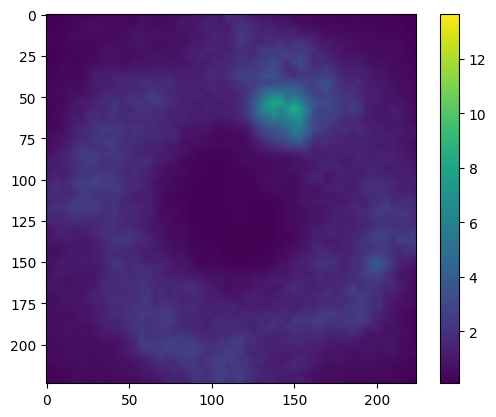

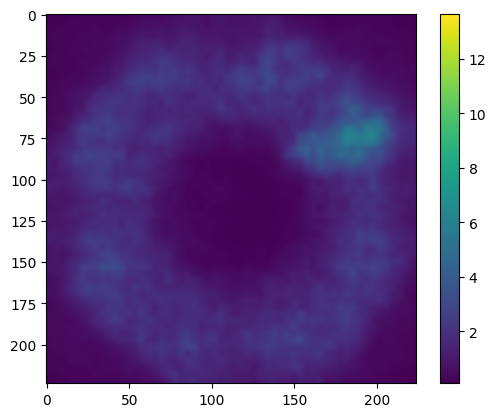

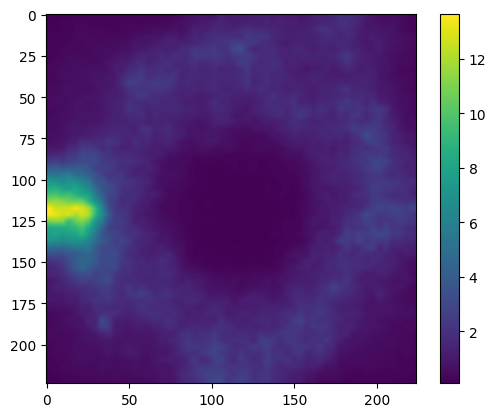

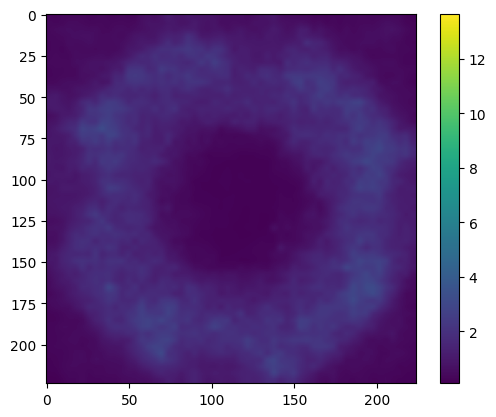

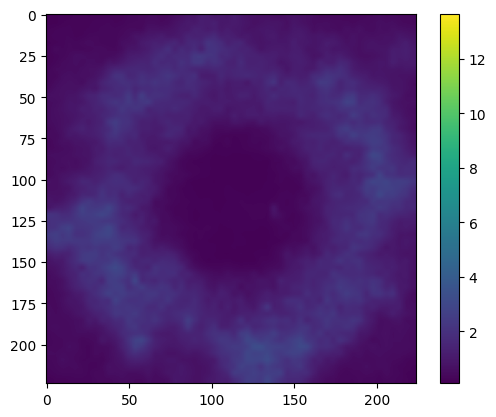

In [ ]:
map_interpolated = torch.zeros((test_vectors.size()[0], 224, 224))
for item in range(len(test_vectors)):
    map_interpolated[item] = F.interpolate(all_maps[item].unsqueeze(0).unsqueeze(0), size=224,mode='bilinear', align_corners=False)

for item in map_interpolated:
    plt.imshow(item, vmin=torch.min(map_interpolated), vmax=torch.max(map_interpolated))
    plt.colorbar()
    plt.show()

### Overlayed result

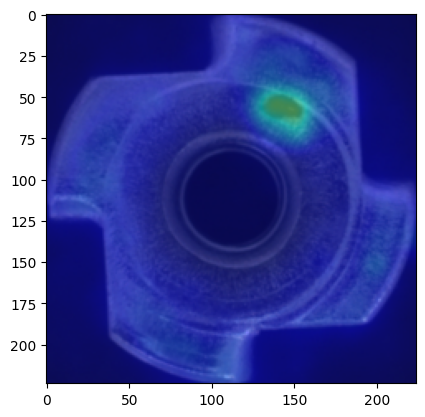

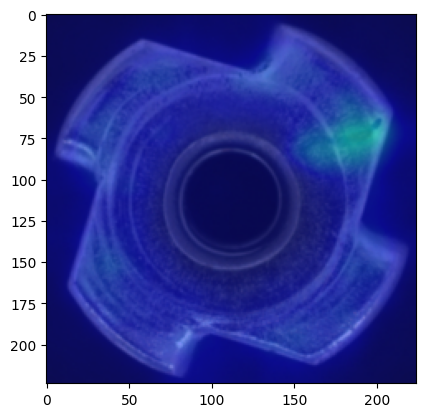

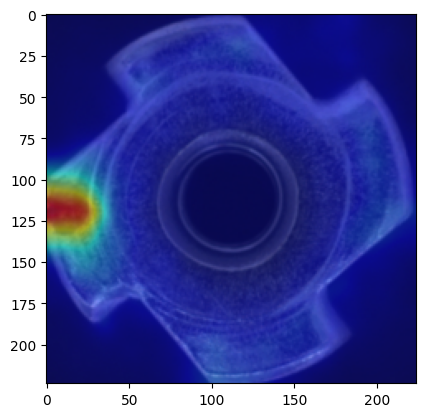

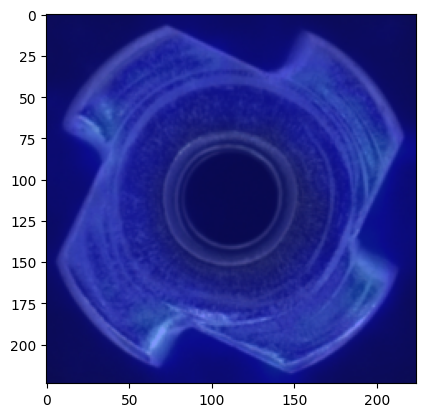

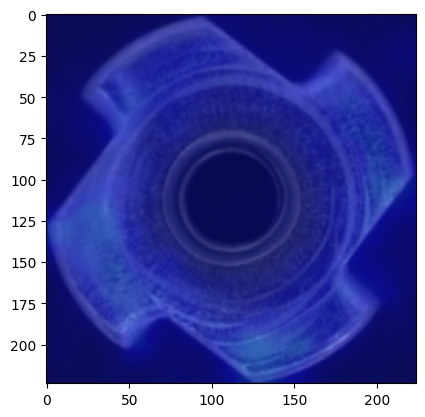

In [ ]:
def overlay_heatmap_on_image(img, heatmap, ratio_img=0.5):
    img = img.astype(np.float32)

    heatmap = 1 - np.clip(heatmap, 0, 1)
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32)

    overlay = (img * ratio_img) + (heatmap * (1 - ratio_img))
    overlay = overlay.astype(np.uint8)
    overlay = np.clip(overlay, 0, 255)
    return overlay

for item in range(len(test_vectors)):
    score_map_ = map_interpolated[item]
    score_map_ = gaussian_filter(score_map_, sigma=4)

    score_map_ = score_map_ - torch.min(map_interpolated).item()
    score_map_ = score_map_ / torch.max(map_interpolated).item()

    # threshold score map

    col_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ])

    col_anomaly = col_preprocess(Image.open(test_paths[item])).permute(1, 2, 0).numpy() * 255

    plt.imshow(overlay_heatmap_on_image(col_anomaly, score_map_, 0.5))
    plt.show()